## Chaotic Data and Prediction Challenges in Machine Learning

Chaotic data arises from *chaotic systems*, which are a type of nonlinear dynamical system characterized by *sensitive dependence on initial conditions*. In these systems, small differences in initial states can lead to drastically different outcomes over time, a phenomenon often referred to as the "butterfly effect." This sensitivity makes chaotic systems unpredictable in the long term, even though they are deterministic—meaning their behavior is governed by fixed rules or equations.

## Characteristics of Chaotic Data
Chaotic data often exhibits the following characteristics:
1. **Complex Patterns**: Chaotic systems are highly structured but appear random, with patterns that do not repeat.
2. **Fractal Nature**: The behavior of chaotic systems can often be analyzed at multiple scales, revealing self-similar structures.
3. **Long-Term Unpredictability**: While short-term predictions may be possible, the data's behavior diverges over time due to the amplification of small differences.

## Challenges for Machine Learning Algorithms
1. **Overfitting**: Machine learning models, especially those based on statistical regularities, may try to capture the noise in chaotic data as meaningful patterns, leading to overfitting. Chaotic data lacks consistent patterns that can be generalized, making it hard to learn robust features.
   
2. **Short-Term vs. Long-Term Prediction**: Machine learning models often struggle to make accurate long-term predictions in chaotic systems. Small prediction errors can compound, leading to significant deviations from actual outcomes.
   
3. **High Sensitivity to Initial Conditions**: Any small error in data collection or initial model conditions can cause large errors in the predictions.
   
4. **Nonlinearity**: Many traditional ML models assume linear relationships, while chaotic systems are inherently nonlinear. Even deep learning models, while powerful, may struggle to fully capture the intricacies of chaotic systems without specific architectural adjustments.

## Specialized Approaches for Chaotic Data
For chaotic data, researchers sometimes turn to *Reservoir Computing* or *Recurrent Neural Networks (RNNs)* that can better model temporal dependencies. However, even these specialized models require careful tuning and are sensitive to parameter choices, making chaotic data prediction an ongoing research challenge.(Theory for the same is given at the end)

## 1. Importing Dependencies

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.integrate import solve_ivp
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

## 2. Reservoir Computing Algorithim

In [26]:
def set_random_seed(seed):
        np.random.seed(seed)

def linear_regression(R, trajectory, beta=0.0001):
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))                # Tikhonov Regularization
    return np.dot(np.dot(trajectory.T, Rt), inverse_part)   

def sigmoid(x):                                                                 #In paper tanh was used, here we are using sigmoid, both give similar result
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

In [27]:
def generate_adjacency_matrix(dim_reservoir, rho, sigma):

    np.random.seed(30)
    graph = nx.gnp_random_graph(dim_reservoir, sigma)                           # Generates an Erdos-Renyi graph of nodes = dim_reservoir and probab of node connection = sigma
    graph = nx.to_numpy_array(graph)

    # Ensure random_array is of the same shape as the graph adjacency matrix.
    random_array = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5)

    # Multiply graph adjacency matrix with random values.
    rescaled = graph * random_array
    return scale_matrix(rescaled, rho)

def scale_matrix(A, rho):
    eigenvalues, _ = np.linalg.eig(A)
    max_eigenvalue = np.amax(eigenvalues)
    A = A/np.absolute(max_eigenvalue) * rho                 # this line makes the spectral radius of matrix A as rho
    return A

In [28]:
class ReservoirComputer:
    def __init__(self, input_dim, reservoir_dim, rho, sigma, seed=None):

        set_random_seed(seed)
        self.input_dim = input_dim
        self.reservoir_dim = reservoir_dim
        self.A = generate_adjacency_matrix(reservoir_dim, rho, sigma)
        self.W_in = 2 * sigma * (np.random.rand(reservoir_dim, input_dim) - 0.5)
        self.W_out = np.zeros((input_dim, reservoir_dim))
        

    def train(self, training_data,training_data_new):
        R = np.zeros((self.reservoir_dim,training_data.shape[0]))
        R[:,0] = np.ones(self.reservoir_dim)
        for i in range(1,training_data.shape[0]):
            u = training_data[i-1]
            R[:,i] = sigmoid(np.dot(self.A, R[:,i-1]) + np.dot(self.W_in, u.T))
        
        columns_to_remove = np.arange(0,1000)
        self.R = np.delete(R, columns_to_remove, axis = 1)                    # Removes the transient data
        self.W_out = linear_regression(self.R, training_data_new)             # Finds ideal weight matrix mapping data[t] to data[t+1]


    def predict(self, steps):
      prediction = np.zeros((steps, self.input_dim))
      r_state = self.R[:,-1]
      prediction[0] = np.transpose(np.dot(self.W_out, r_state))
      for i in range (1, steps):
          r_state = sigmoid(np.dot(self.A, r_state) + np.dot(self.W_in, prediction[i-1].T))
          prediction[i] = np.transpose(np.dot(self.W_out, r_state))

      return prediction

## 3. Using to predict Lorentz system's Data

In [29]:
def lorenz_equations(t, X, sigma, rho, beta):
    x, y, z = X
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


sigma = 10
rho = 28
beta = 8/3

XYZ_initial = [1, 1, 1]
t_span = (0, 1000)


sol = solve_ivp(lorenz_equations, t_span, XYZ_initial, args=(sigma, rho, beta), dense_output=True)
t = np.linspace(t_span[0], t_span[1], 50000)
X = sol.sol(t)
x_list, y_list, z_list = X[0], X[1], X[2]


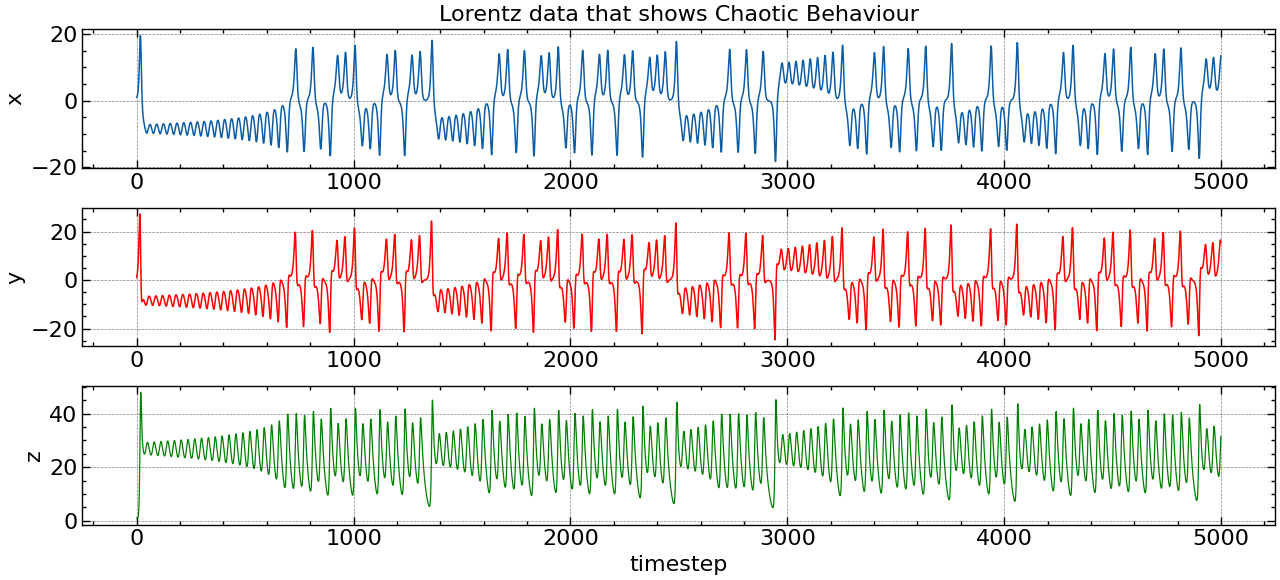

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(13, 6))

# Plot data on each subplot
axs[0].plot(x_list[0:5000], label="x", lw=1.1)
axs[0].set_ylabel("x")
axs[0].set_title("Lorentz data that shows Chaotic Behaviour")

axs[1].plot(y_list[0:5000], label="y", color='r', lw=1.1)
axs[1].set_ylabel("y")

axs[2].plot(z_list[0:5000], label="z", color='g', lw=.9)
axs[2].set_ylabel("z")
axs[2].set_xlabel("timestep")

fig.tight_layout()

plt.show()


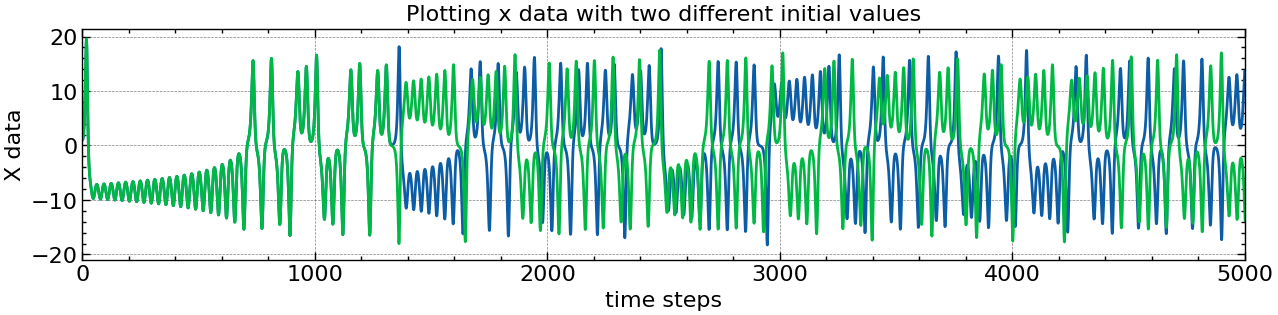

In [31]:
sol = solve_ivp(lorenz_equations, t_span, [1.000001,1.000001,1.000001], args=(sigma, rho, beta), dense_output=True)
t = np.linspace(t_span[0], t_span[1], 50000)
X_new = sol.sol(t)
plt.figure(figsize=(15,3))
plt.title("Plotting x data with two different initial values")
plt.plot(x_list,label="x_initial = 1")
plt.plot(X_new[0],label="x_initial = 1.000001")
plt.ylabel("X data")
plt.xlabel("time steps")
plt.xlim(0,5000)
plt.show()

We could see above how the data is very dependent on initial conditions

In [ ]:
data = []                                                        
for i in range(len(x_list)):                                     # Obtaining training and testing data
    u_i = [x_list[i], y_list[i], z_list[i]]
    data.append(u_i)

data_without_transient = data[10000:]
data_length = len(data_without_transient)                         # removed transient 
training_percentage = 0.7
training_data = np.array(data_without_transient[:30000])
train_without_transient = training_data[1000:]                   # removes first 1000 rows as warmup(correspondingly removed from the R matrix)
valid_data = np.array(data_without_transient[30000:])            # Testing data

In [33]:
reservoir_dim = 1000                                    
model = ReservoirComputer(3, reservoir_dim, 0.8, 0.035,seed=30)      
model.train(training_data, train_without_transient)
predicted_data = model.predict(len(valid_data))

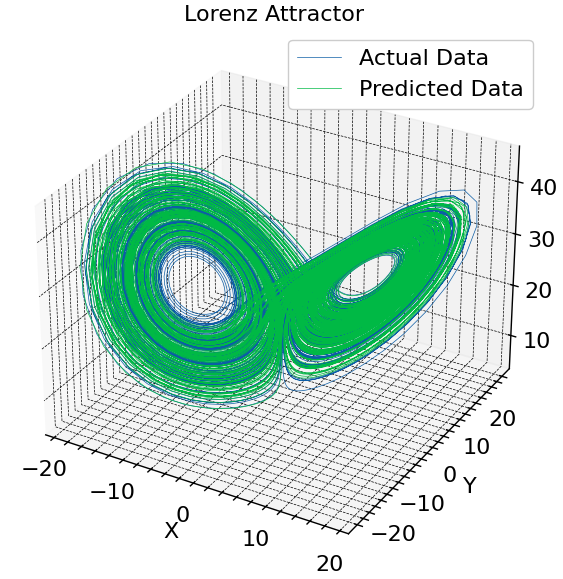

In [34]:
fig = plt.figure(figsize=(10, 7))

x_data = valid_data[:, 0]
y_data = valid_data[:, 1]
z_data = valid_data[:, 2]

x_pred = predicted_data[:, 0]
y_pred = predicted_data[:, 1]
z_pred = predicted_data[:, 2]

ax = fig.add_subplot(111, projection='3d')

ax.plot(x_data, y_data, z_data, lw=0.5, label="Actual Data")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, label="Predicted Data")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor')
ax.legend()
plt.show()

This is where the butterfly effect name comes from :)

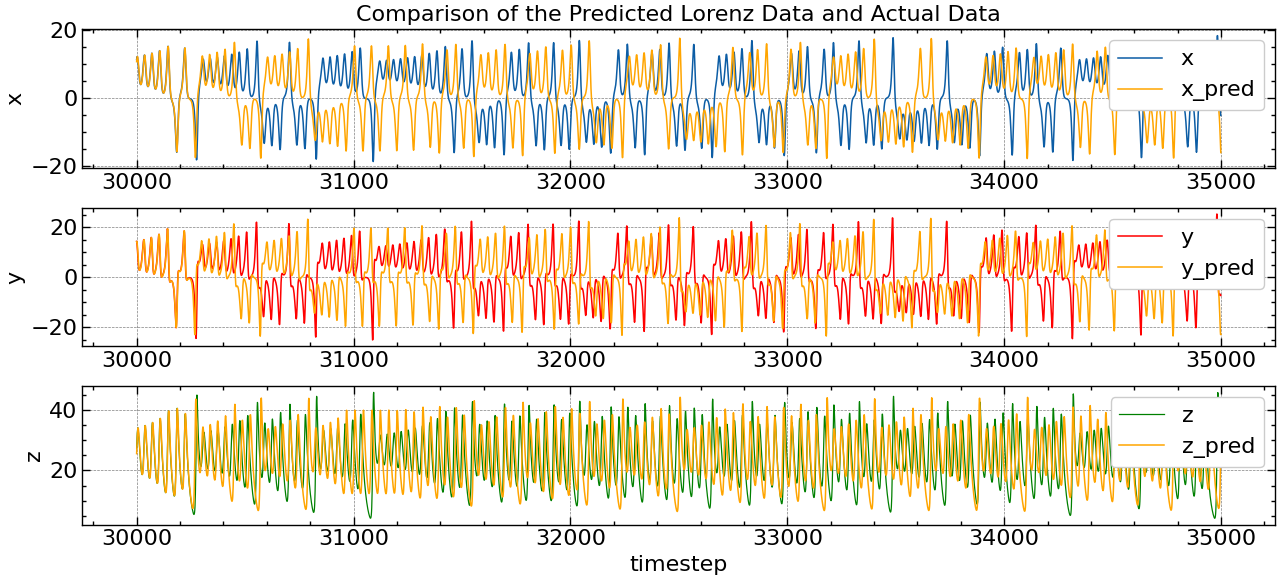

In [35]:

fig, axs = plt.subplots(3, 1, figsize=(13, 6))

timesteps = [*range(training_data.shape[0], data_length, 1)]

# Plot data on each subplot
axs[0].plot(timesteps[:5000], x_data[:5000], label="x", lw=1.1)
axs[0].plot(timesteps[:5000], x_pred[:5000], label="x_pred", color='orange', lw=1.1)  
axs[0].set_ylabel("x")
axs[0].set_title("Comparison of the Predicted Lorenz Data and Actual Data")
axs[0].legend(loc='upper right')

axs[1].plot(timesteps[:5000], y_data[:5000], label="y", color='r', lw=1.1)
axs[1].plot(timesteps[:5000], y_pred[:5000], label="y_pred", color='orange', lw=1.1)  
axs[1].set_ylabel("y")
axs[1].legend(loc='upper right')

axs[2].plot(timesteps[:5000], z_data[:5000], label="z", color='g', lw=.9)
axs[2].plot(timesteps[:5000], z_pred[:5000], label="z_pred", color='orange', lw=1.1)  
axs[2].set_ylabel("z")
axs[2].set_xlabel("timestep")
axs[2].legend(loc='upper right')

fig.tight_layout()

plt.show()


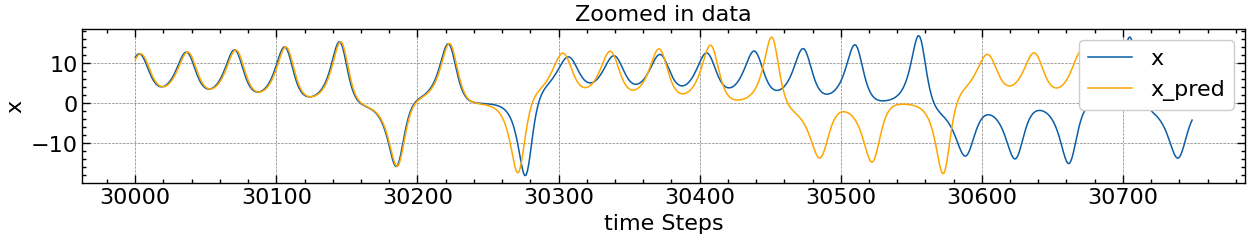

In [36]:
plt.figure(figsize=(15,2))
plt.plot(timesteps[0:750], x_data[:750], label="x", lw=1.1)
plt.plot(timesteps[0:750], x_pred[:750], label="x_pred", color='orange', lw=1.1)  
plt.ylabel("x")
plt.xlabel("time Steps")
plt.title("Zoomed in data")
plt.legend(loc='upper right')
plt.show()

In [37]:
def nrmse(y_true, y_pred, normalization='range'):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    
    if normalization == 'range':
        norm_factor = np.max(y_true) - np.min(y_true)
    elif normalization == 'mean':
        norm_factor = np.mean(y_true)
    else:
        raise ValueError("Normalization method should be either 'range' or 'mean'")
    
    nrmse_value = rmse / norm_factor
    return nrmse_value

true_data = valid_data
predicted_data = predicted_data

print("NRMSE (normalized by range):", nrmse(true_data, predicted_data, normalization='range'))
print("NRMSE (normalized by mean):", nrmse(true_data, predicted_data, normalization='mean'))


NRMSE (normalized by range): 0.16618747717212615
NRMSE (normalized by mean): 1.4240071772801737


## Algorithm

- A reservoir computing machine projects an *n*-dimensional input channel $u(t)$ into a higher *m*-dimensional space through a weight matrix $W_{in}$. The adjacency matrix (*m × m*) of the reservoir network $A$ is responsible for including memories of the reservoir state. The matrices $W_{in}$ and $A$ are initially chosen and are fixed throughout the training process. $W_{in}$ is chosen from a uniform random distribution ranging from $[-b, b]$. Often, $A$ is chosen to be the adjacency matrix of an Erdős-Rényi model network, with connection probability $\sigma$ and scaling $\rho$. For a given value of the spectral radius, $A$ is scaled so that its largest eigenvalue is $\rho$. The reservoir state $r(t)$ is updated by the following equation for $N_{t}$ time steps:
  
  $$
      r[i+1] = (1-\alpha)r[i] + \alpha \; \tanh(Ar[i]+W_{in}u[i+1])
  $$
  
  where $\alpha$ is known as the leakage rate. The updated reservoir state is influenced by both the previous reservoir state and the current input state, with $\alpha$ dictating the relative dominance of these two factors in determining the new reservoir state. During the training phase, the aim is to minimize the difference between the actual and predicted output. To achieve this, the updated reservoir states are stored and stacked to form a matrix $R$ of dimensions (*m × N_t*). To avoid any unnecessary symmetries in the system, we update the matrix $R$ by squaring only the odd rows. The actual output, which is the target variable, is also stacked to form a matrix $U$ of dimensions (*n × N_t*). The output weight matrix is then calculated using Tikhonov regularization:

  $$
      W_{out} = U.R^T.(RR^T + \beta I)^{-1}
  $$

  In the testing phase, the output of the current state acts as the input for the next state, and the output $v(t)$ is given by $W_{out}r(t)$.

- Reservoir Computing (RC) models rely heavily on hyperparameters like reservoir size, spectral radius, and regularization parameters, all of which significantly impact model performance. Finding the optimal hyperparameters is challenging due to their complex, non-linear effects and the need for extensive trial and error. To address this, I employed Bayesian optimization, a technique that uses a probabilistic model to efficiently explore and exploit parameter spaces, achieving optimal or near-optimal solutions with fewer evaluations than traditional methods.


## Why Reservoir Computing Algorithms Work Better for Predicting Chaotic Data


Reservoir Computing (RC) has several advantages that make it particularly effective for predicting chaotic data compared to traditional machine learning models. Here are some key reasons:

### 1. Dynamic Memory Capacity
- **Memory of Past States:** Reservoir Computing utilizes a dynamic reservoir that retains information about past inputs. This memory allows the model to capture temporal dependencies and complex dynamics inherent in chaotic systems.
- **High Dimensionality:** The reservoir maps input data into a high-dimensional space, which can represent the underlying structure of chaotic attractors more effectively.

### 2. Nonlinear Transformations
- **Rich Dynamics:** The nonlinear activation functions in the reservoir introduce rich dynamics that can model complex behaviors found in chaotic systems. This capability enables the algorithm to learn from the intricate patterns in chaotic data.
- **Universal Approximation:** The reservoir's architecture can approximate any nonlinear function, making it suitable for capturing the complex relationships between inputs and outputs in chaotic systems.

### 3. Robustness to Noise
- **Noise Resilience:** RC algorithms can be more robust to noise in the input data. The reservoir's inherent dynamics can help filter out irrelevant information, leading to more reliable predictions in the presence of noise.

### 4. Simplified Training Process
- **Fixed Reservoir:** In Reservoir Computing, only the output weights need to be trained, while the reservoir itself is fixed. This reduces the complexity of the training process, making it easier to implement and tune compared to models where all parameters must be learned.
- **Efficient Learning:** The training process often requires fewer data points and can converge more quickly, which is particularly advantageous when working with limited or sparse data.

### 5. Adaptability to System Changes
- **Parameter Awareness:** Some RC architectures can incorporate external parameters into the reservoir dynamics, allowing the model to adapt to changes in the underlying system more effectively. This adaptability is crucial for modeling chaotic systems that may exhibit transitions between different dynamical regimes.

### 6. Minimal Tuning Required
- **Hyperparameter Optimization:** While hyperparameters like reservoir size and spectral radius do influence performance, RC often requires less fine-tuning compared to other machine learning models, which may have more complex architectures and require extensive hyperparameter searches.
